In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx

In [44]:
import time
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from libs.lizi.my_magi import MyMagiModel
from libs.lizi.my_magi.config import MagiConfig
from libs.lizi.my_magi.utils import UnionFind
from libs.lizi.my_magi.utils import read_image_as_np_array as read_image
from numpy.typing import NDArray
from PIL import Image
from rich.pretty import pprint as pp
from torchmetrics.functional.pairwise import pairwise_cosine_similarity
from torchvision.transforms import v2
from transformers.modeling_utils import load_state_dict

In [4]:
torch.cuda.is_available()

True

---

In [117]:
def resize_image_to_match(input_image_path, match_image_path, output_image_path):
    original_image = Image.open(input_image_path)
    match_image = Image.open(match_image_path)
    width, height = match_image.size
    
    if original_image.width < match_image.width:
        new_width = match_image.width
        new_height = int(original_image.height * (match_image.width / original_image.width))
    elif original_image.height < match_image.height:
        new_width = int(original_image.width * (match_image.height / original_image.height))
        new_height = match_image.height
    else:
        return  # Если исходное изображение уже больше, ничего делать не нужно
    
    resized_image = original_image.resize((new_width, new_height), Image.LANCZOS)
    resized_image.save(output_image_path)




In [118]:
# Путь к меньшему изображению
smaller_image_path = "data/color_jojo/24.jpg"
# Путь к большему изображению
larger_image_path = "data/color_jojo/5.jpg"
# Путь, куда будет сохранено измененное изображение
output_path = 'new_24.jpg'

# Изменяем размер меньшего изображения, чтобы он соответствовал размеру большего
resize_image_to_match(smaller_image_path, larger_image_path, output_path)

---

In [120]:
image_color = Image.open("data/color_jojo/5.jpg")

In [121]:
image_color.size

(780, 1200)

In [122]:
image_bw = Image.open("data/color_jojo/new_24.jpg")

In [123]:
image_bw.size

(780, 1252)

In [133]:
images_col_test = [read_image("data/color_jojo/5.jpg")]

In [130]:
images_bw_test = [read_image("data/color_jojo/new_24.jpg")]

In [128]:
image_model_bw = [image_bw]

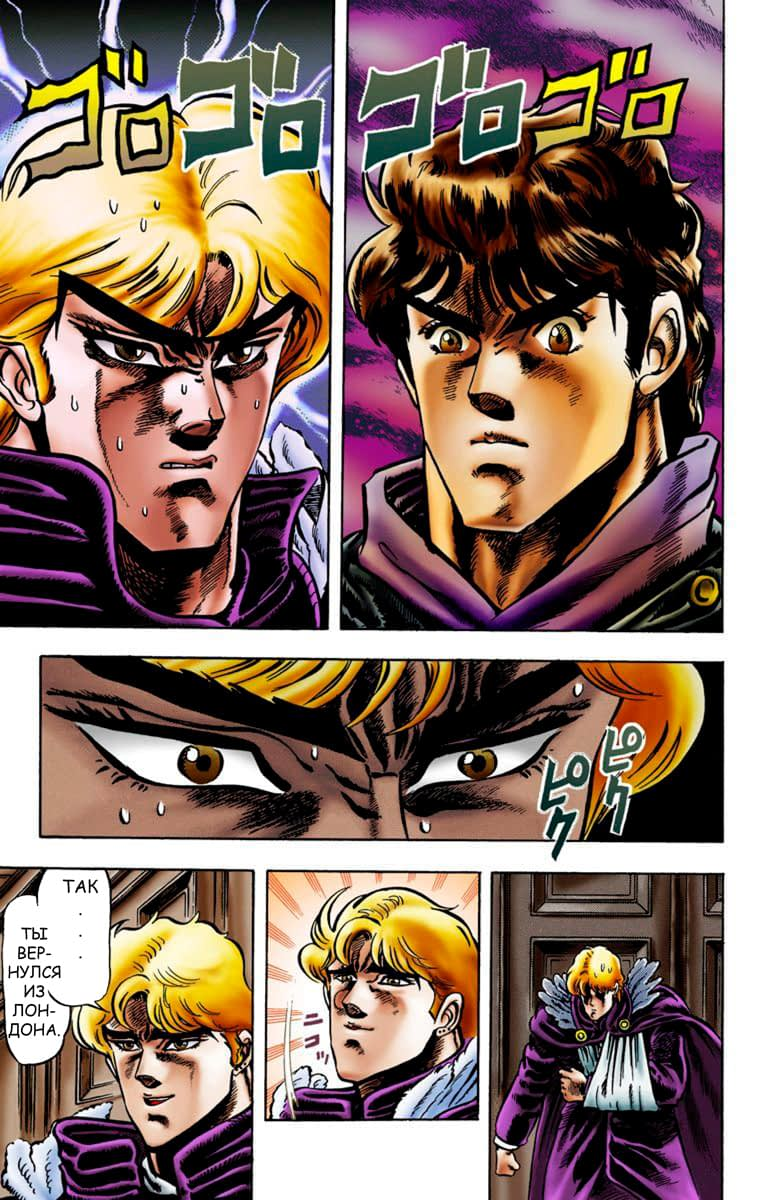

In [125]:
image_color

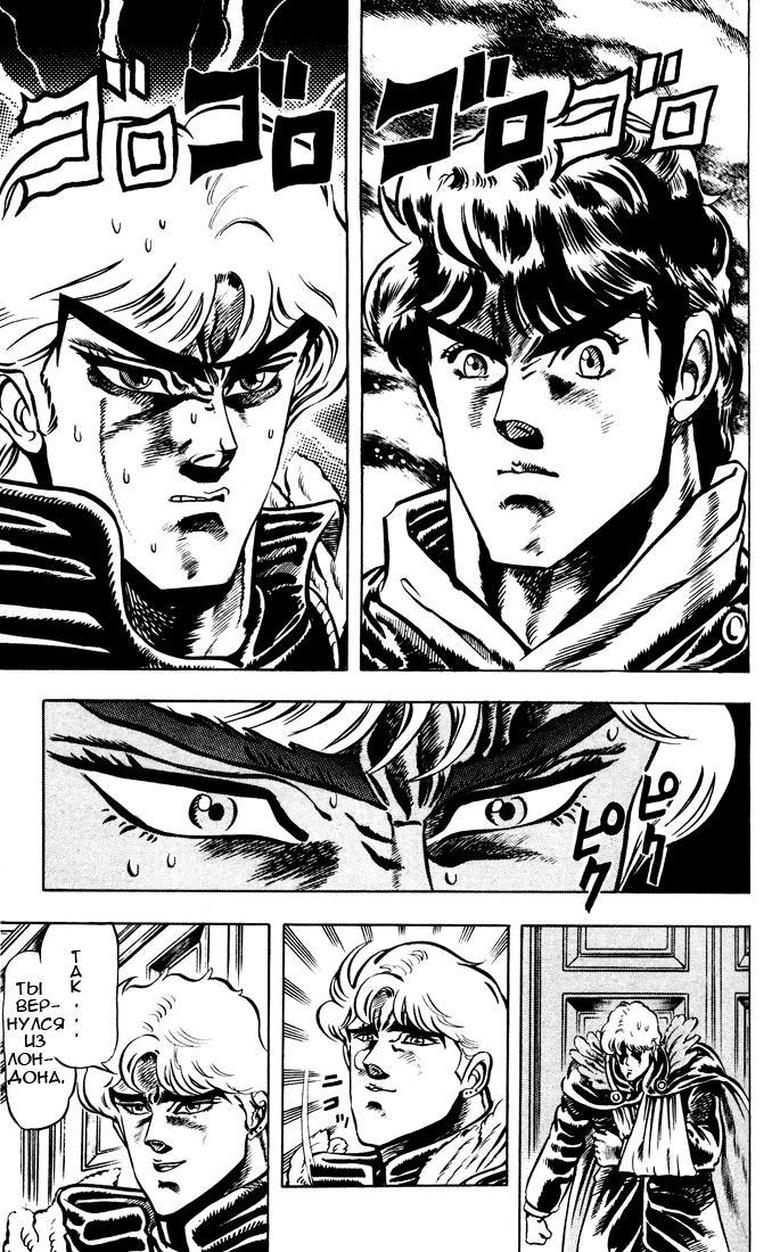

In [124]:
image_bw

---

### Лишнее

In [105]:
new_image_bw.size

(300, 481)

In [108]:
image_color = Image.open("data/color_jojo/5.jpg")
new_image_color = v2.functional.resize(image_color, 300)

In [109]:
new_image_color.size

(300, 461)

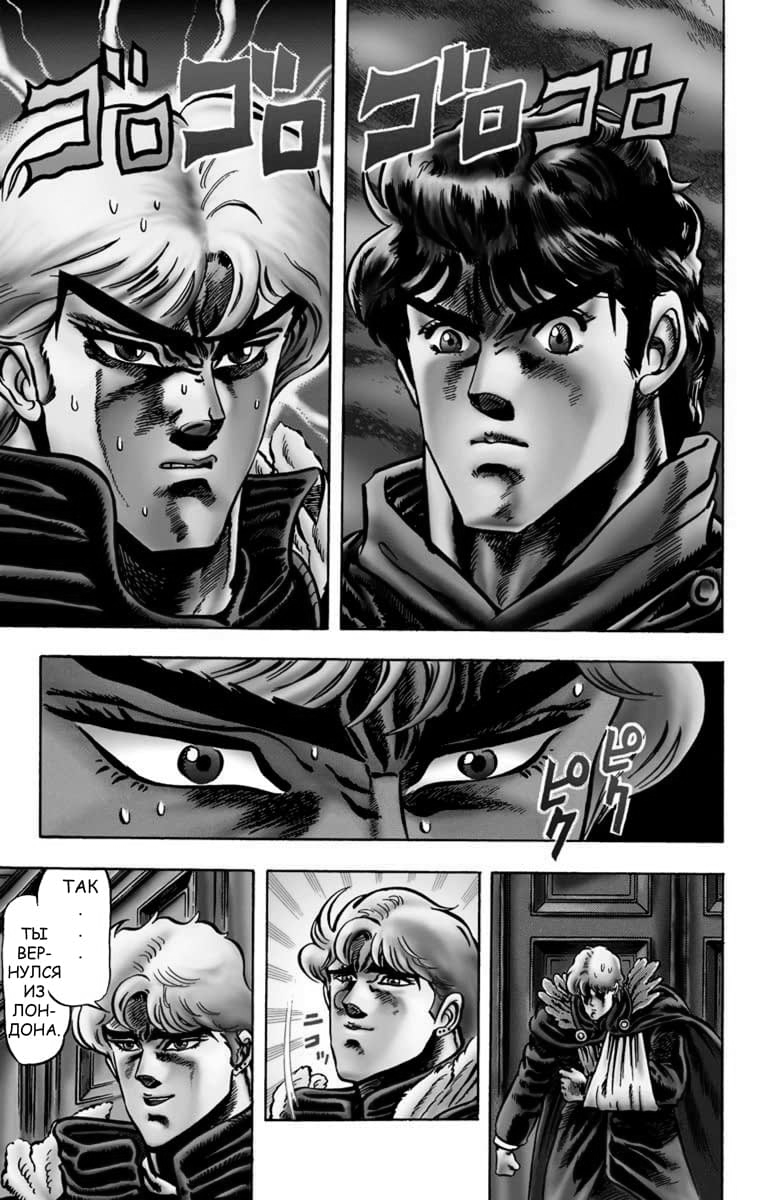

In [101]:
v2.functional.to_grayscale(image_color)

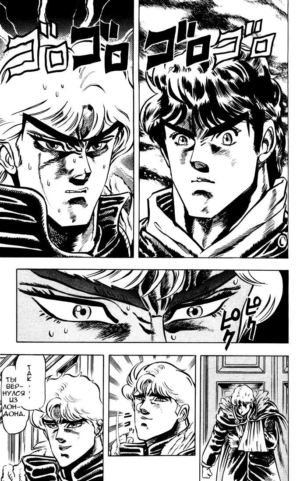

In [98]:
image_bw = Image.open("data/color_jojo/24.jpg")
v2.functional.resize(image_bw, 300)

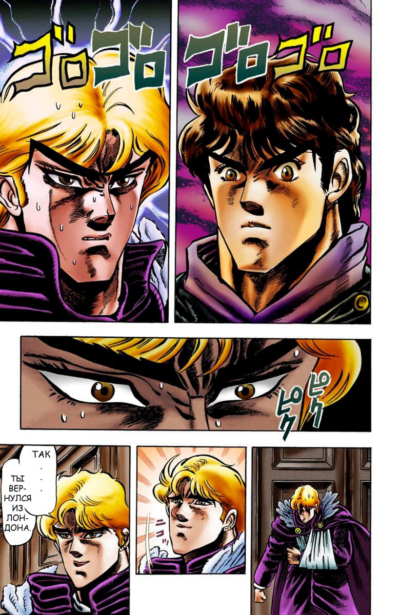

In [99]:
resizer = v2.Resize(size=(400,))
resizer(image_color)

array([[[  5,   5,   5],
        [  0,   0,   0],
        [  2,   2,   2],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0,   0,   0],
        [ 24,  24,  24],
        [ 10,  10,  10],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 21,  21,  21],
        [  0,   0,   0],
        [  1,   1,   1],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[248, 248, 248],
        [247, 247, 247],
        [ 55,  55,  55],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [254, 254, 254],
        [ 43,  43,  43],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[249, 249, 249],
        [253, 253, 253],
        [ 40,  40,  40],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [40]:
new_color_image = image_color.resize((1200,780))

In [41]:
new_color_image.show()

AttributeError: 'NoneType' object has no attribute 'show'

---

### v

In [8]:
state_dict = load_state_dict(str(Path("models/magi/pytorch_model.bin").resolve()))
state_dict.keys()

dict_keys(['ocr_model.encoder.embeddings.cls_token', 'ocr_model.encoder.embeddings.position_embeddings', 'ocr_model.encoder.embeddings.patch_embeddings.projection.weight', 'ocr_model.encoder.embeddings.patch_embeddings.projection.bias', 'ocr_model.encoder.encoder.layer.0.attention.attention.query.weight', 'ocr_model.encoder.encoder.layer.0.attention.attention.key.weight', 'ocr_model.encoder.encoder.layer.0.attention.attention.value.weight', 'ocr_model.encoder.encoder.layer.0.attention.output.dense.weight', 'ocr_model.encoder.encoder.layer.0.attention.output.dense.bias', 'ocr_model.encoder.encoder.layer.0.intermediate.dense.weight', 'ocr_model.encoder.encoder.layer.0.intermediate.dense.bias', 'ocr_model.encoder.encoder.layer.0.output.dense.weight', 'ocr_model.encoder.encoder.layer.0.output.dense.bias', 'ocr_model.encoder.encoder.layer.0.layernorm_before.weight', 'ocr_model.encoder.encoder.layer.0.layernorm_before.bias', 'ocr_model.encoder.encoder.layer.0.layernorm_after.weight', 'ocr_mo

In [9]:
config: MagiConfig = MagiConfig.from_json_file(Path("libs/lizi/my_magi/config.json").resolve())  # type: ignore
model = MyMagiModel(config)

In [10]:
model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['ocr_model.encoder.embeddings.cls_token', 'ocr_model.encoder.embeddings.position_embeddings', 'ocr_model.encoder.embeddings.patch_embeddings.projection.weight', 'ocr_model.encoder.embeddings.patch_embeddings.projection.bias', 'ocr_model.encoder.encoder.layer.0.attention.attention.query.weight', 'ocr_model.encoder.encoder.layer.0.attention.attention.key.weight', 'ocr_model.encoder.encoder.layer.0.attention.attention.value.weight', 'ocr_model.encoder.encoder.layer.0.attention.output.dense.weight', 'ocr_model.encoder.encoder.layer.0.attention.output.dense.bias', 'ocr_model.encoder.encoder.layer.0.intermediate.dense.weight', 'ocr_model.encoder.encoder.layer.0.intermediate.dense.bias', 'ocr_model.encoder.encoder.layer.0.output.dense.weight', 'ocr_model.encoder.encoder.layer.0.output.dense.bias', 'ocr_model.encoder.encoder.layer.0.layernorm_before.weight', 'ocr_model.encoder.encoder.layer.0.layernorm_before.bias', 'ocr_model.encoder.encoder

In [11]:
model.cuda() # type: ignore

MyMagiModel(
  (crop_embedding_model): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTMAELayer(
          (attention): ViTMAEAttention(
            (attention): ViTMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_features=

---

### w

In [131]:
crop_bboxes_bw, crop_embeddings_for_batch_bw, image_bboxes_bw, character_scores_bw = model.get_crops_and_embeddings(images_bw_test)

In [134]:
crop_bboxes_col, crop_embeddings_for_batch_col, image_bboxes_col, character_scores_col = model.get_crops_and_embeddings(images_col_test)

In [39]:
image_bw.shape

(1200, 780, 3)

In [32]:
image_color.shape

(1100, 685, 3)

---

In [143]:
crop_embeddings_for_batch_col[0].shape

torch.Size([7, 768])

In [144]:
crop_embeddings_for_batch_bw[0].shape

torch.Size([7, 768])

In [145]:
pcs = pairwise_cosine_similarity(crop_embeddings_for_batch_bw[0], crop_embeddings_for_batch_col[0])
pcs.shape  

torch.Size([7, 7])

In [146]:
pp(pcs)

tensor([[0.5423, 0.8765, 0.8752, 0.8911, 0.8493, 0.8432, 0.8964],
│   │   [0.6229, 0.9668, 0.8621, 0.9649, 0.8710, 0.8732, 0.9387],
│   │   [0.9249, 0.6367, 0.6583, 0.5561, 0.5942, 0.6916, 0.5990],
│   │   [0.6667, 0.8711, 0.8231, 0.8480, 0.8639, 0.9543, 0.8159],
│   │   [0.6014, 0.8203, 0.8072, 0.8203, 0.8783, 0.8131, 0.8343],
│   │   [0.6366, 0.9570, 0.8374, 0.9619, 0.8684, 0.8567, 0.9402],
│   │   [0.5903, 0.9030, 0.8512, 0.9095, 0.8470, 0.8320, 0.9307]],
│      device='cuda:0', grad_fn=<MmBackward0>)

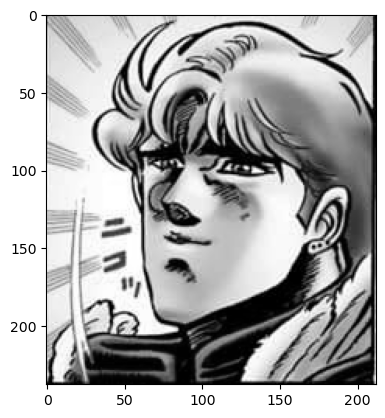

In [154]:
plt.imshow(image_bboxes_col[0][2])

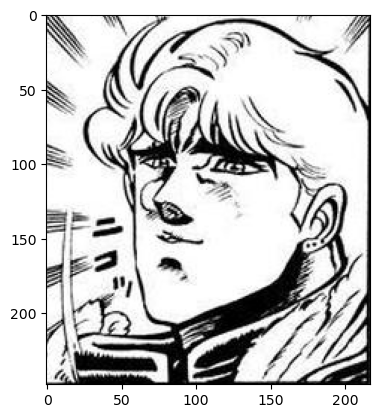

In [153]:
plt.imshow(image_bboxes_bw[0][0])

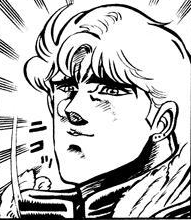

In [24]:
Image.fromarray(image_bboxes_co[0][0])

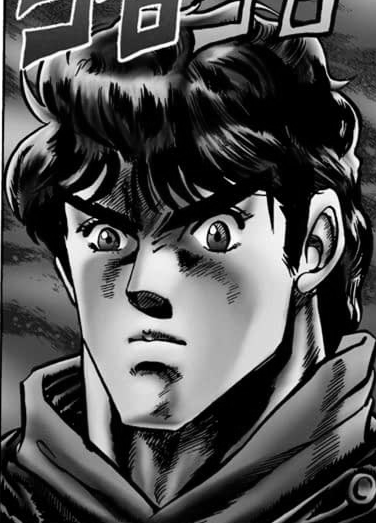

In [25]:
Image.fromarray(image_bboxes_bw[0][0])

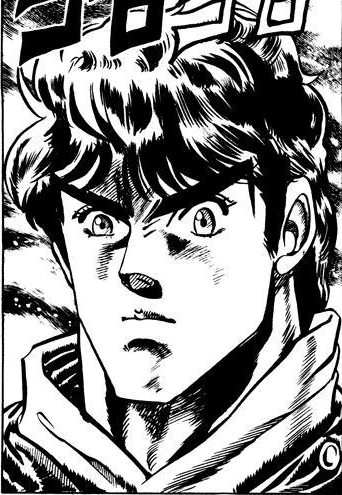

In [27]:
Image.fromarray(image_bboxes_co[0][1])